# Using local and remote DASK on CMS Data

CMS datasets tend to be quite large. We should be able to use DASK.

In [1]:
from func_adl_servicex import ServiceXSourceCMSRun1AOD
from servicex.servicex import ServiceXDataset
from coffea.processor.servicex import Analysis, DataSource, DaskExecutor
from func_adl import ObjectStream
from hist import Hist

import asyncio
from typing import List

## Defining the base query

* We are using the CMS Run 1 AOD file type here
* No global event cuts

In [2]:
ds = ServiceXSourceCMSRun1AOD('cernopendata://dummy')
ds.return_qastle = True  # Magic

In [3]:
## Selecting Clean Objects

In [4]:
leptons_source = (
    ds
    .Select(lambda e: {
        "m": e.Muons("muons"),
        "e": e.GsfElectrons("gsfElectrons"), 
        "p": e.Vertex("offlinePrimaryVertices")[0].position()
    })
)

In [5]:
data_leptons = (
     leptons_source
     .Select(lambda i: {
          "m": i.m
               .Where(lambda m: m.isPFMuon()
                         and m.isPFIsolationValid()
                         and isNonnull(m.globalTrack())
                         and abs(sqrt((m.globalTrack().dxy(i.p) * m.globalTrack().dxy(i.p))
                                   + (m.globalTrack().dz(i.p) * m.globalTrack().dz(i.p)))
                              / sqrt((m.globalTrack().d0Error() * m.globalTrack().d0Error())
                                        + (m.globalTrack().dzError() * m.globalTrack().dzError()))) < 4.0
                         and abs((m.globalTrack()).dxy(i.p)) < 0.5
                         and abs((m.globalTrack()).dz(i.p)) < 1.
                         and ((m.pfIsolationR04()).sumChargedHadronPt
                              + (m.pfIsolationR04()).sumNeutralHadronEt
                              + (m.pfIsolationR04()).sumPhotonEt) / m.pt() < 0.4
                         and m.pt() > 5.
                         and abs(m.eta()) < 2.4
               ),
          "e": i.e
               .Where(lambda e: e.passingPflowPreselection()
                         and e.pt() > 7.
                         and abs(e.superCluster().eta()) < 2.5
                         and e.gsfTrack().trackerExpectedHitsInner().numberOfHits() <= 1
                         and abs(sqrt((e.gsfTrack().dxy(i.p) * e.gsfTrack().dxy(i.p))
                                   + (e.gsfTrack().dz(i.p) * e.gsfTrack().dz(i.p)))
                              / sqrt((e.gsfTrack().d0Error() * e.gsfTrack().d0Error())
                                        + (e.gsfTrack().dzError() * e.gsfTrack().dzError()))) < 4.
                         and abs(e.gsfTrack().dxy(i.p)) < 0.5 and abs(e.gsfTrack().dz(i.p)) < 1.
                         and (e.isEB() or e.isEE())
                         and (e.pfIsolationVariables().chargedHadronIso
                              + e.pfIsolationVariables().neutralHadronIso
                              + e.pfIsolationVariables().photonIso) / e.pt() < 0.4
                         )
     })
)

And pull out the columns we need for selection in the code

In [6]:
cms_selection = (
    data_leptons
    .Select(lambda i: (
        i.m.Select(lambda m: m.pt()),
        i.m.Select(lambda m: m.phi()),
        i.m.Select(lambda m: m.eta()),
        i.m.Select(lambda m: m.energy()),
        i.m.Select(lambda m: m.charge()),
        i.e.Select(lambda m: m.pt()),
        i.e.Select(lambda m: m.phi()),
        i.e.Select(lambda m: m.eta()),
        i.e.Select(lambda m: m.energy()),
        i.e.Select(lambda m: m.charge()),
    ))
    .AsROOTTTree('file.root', 'treeme', columns = [
        'mu_pt', 'mu_phi', 'mu_eta', 'mu_energy', 'mu_charge',
        'el_pt', 'el_phi', 'el_eta', 'el_energy', 'el_charge',
    ])
)

## Performing the Analysis

We are re-using, almost line-for-line, the work of an IRIS-HEP 2021 fellow, Brian Cruz, there. He developed a notebook that run on nano-aod's, and then converted the 

In [7]:
class CMS_Higgs_4L(Analysis):
    '''Run the 4 Lepton analysis on CMS open data Run 1 AOD's
    '''
    @staticmethod
    def process(events):
        from collections import defaultdict
        import awkward as ak
        import numpy as np
        import numpy as np

        import awkward as ak

        sumw = defaultdict(float)
        mass_hist = (Hist.new
                     .Reg(60, 60, 180, name='mass', label='$m_{4\ell}$ [GeV]')
                     .StrCat([], name='dataset', label='Cut Type', growth=True)
                     .StrCat([], name='channel', label='Channel', growth=True)
                     .Int64()
                    )

        dataset = events.metadata['dataset']
        
        good_mu = events.mu
        good_e = events.el

        # This code is copied directly from Brian Cruz's CMS Notebook that
        # uses the converted nano-aod's
        
        # function that finds the best combination of pairs with a mass closest to the real Z mass
        mZ = 91.1876
        def closest(pair):
            delta = abs(mZ - pair.mass[:])
            closest_masses = np.min(delta, axis=-1)
            the_closest = (delta == closest_masses)
            return the_closest
        
        ### Higgs to 4 muons ###
        
        # entries with 4 muons
        mu4 = good_mu[ak.num(good_mu) >= 4]

        if len(mu4) > 0:

            # sort the events from highest to lowest transverse momentum
            mu4_sorted = mu4[ak.argsort(mu4.pt, axis=-1, ascending=False)]

            # select the first 4 muons from the sorted mu4
            f4_mu4_sorted = mu4_sorted[:,0:4]

            # select the 4 muons with a zero net charge
            f4c0_mu4_sorted = f4_mu4_sorted[ak.sum(f4_mu4_sorted[:,:,"charge"], axis=-1) == 0]

            # creating muon pairs
            muon_pair = ak.combinations(f4c0_mu4_sorted, 2)

            # combinations with zero net charge
            muon_pair_c0 = muon_pair[(muon_pair["0"].charge + muon_pair["1"].charge)==0]

            # get the closest Z boson (Za) and farthest Z boson (Zb)
            Z_muons = (muon_pair_c0["0"] + muon_pair_c0["1"])
            Za_muons = closest(Z_muons)
            Zb_muons = Za_muons[:,::-1]

            # best combination of muons
            Za_2mu = muon_pair_c0[Za_muons]
            Zb_2mu = muon_pair_c0[Zb_muons]

            # flatten the arrays
            Za_mu = ak.flatten(Za_2mu)
            Zb_mu = ak.flatten(Zb_2mu)

            # Mass requirement 
            M_Za_mu = (((Za_mu["0"]+Za_mu["1"]).mass>40)&((Za_mu["0"]+Za_mu["1"]).mass<120))
            M_Zb_mu = (((Zb_mu["0"]+Zb_mu["1"]).mass>12)&((Zb_mu["0"]+Zb_mu["1"]).mass<120))

            # Transverse momentum requirement
            pt_Z_mu = (Za_mu["0"].pt>20)&(Za_mu["1"].pt>10)

            # applying the cuts to get the good Z bosons
            good_Za_mu = Za_mu[pt_Z_mu&M_Za_mu&M_Zb_mu]
            good_Zb_mu = Zb_mu[pt_Z_mu&M_Za_mu&M_Zb_mu]

            # adding the Z boson pairs (Higgs decay to 4 muons calculation)
            higgs4mu = good_Za_mu['0']+good_Za_mu['1'] + good_Zb_mu['0']+good_Zb_mu['1']

            # applying a mass range
            Higgs_4mu = higgs4mu[higgs4mu.mass>70]

            mass_hist.fill(
                mass=Higgs_4mu.mass,
                channel='4mu',
                dataset=dataset
            )
        
        ### Higgs to 4 muons ends ###

        ### Higgs to 4 electrons starts ###

        # entries with four electrons
        e4 = good_e[ ak.num(good_e)>=4 ]
        
        if len(e4) > 0:

            # sorting the events from high to low transverse momentum
            e4_sorted = e4[ak.argsort(e4.pt, axis=-1, ascending=False)]

            # selecting the first 4 electrons from the sorted e4
            f4_e4_sorted = e4_sorted[:,0:4]

            # selecting the 4 electrons with a zero net charge
            f4c0_e4_sorted = f4_e4_sorted[ ak.sum(f4_e4_sorted[:,:,"charge"], axis=-1)==0 ]

            # creating electron pairs
            e_pair = ak.combinations(f4c0_e4_sorted, 2)

            # combinations with zero net charge
            e_pair_c0 = e_pair[ (e_pair["0"].charge + e_pair["1"].charge)==0 ]

            # get the closest Z boson (Za) and farthest Z boson (Zb)
            Z_electrons = ( e_pair_c0["0"] + e_pair_c0["1"] )
            Za_electrons = closest(Z_electrons)
            Zb_electrons = Za_electrons[:,::-1]

            # best combination of electrons
            Za_2e = e_pair_c0[Za_electrons]
            Zb_2e = e_pair_c0[Zb_electrons]

            # flatten the arrays
            Za_e = ak.flatten(Za_2e)
            Zb_e = ak.flatten(Zb_2e)

            # mass requirement
            M_Za_e = (((Za_e["0"]+Za_e["1"]).mass>40)&((Za_e["0"]+Za_e["1"]).mass<120))
            M_Zb_e = (((Zb_e["0"]+Zb_e["1"]).mass>12)&((Zb_e["0"]+Zb_e["1"]).mass<120))

            # transverse momentum requirement
            pt_Z_e = (Za_e["0"].pt>20)&(Za_e["1"].pt>10)

            # applying the cuts to get the good Z bosons
            good_Za_e = Za_e[pt_Z_e&M_Za_e&M_Zb_e]
            good_Zb_e = Zb_e[pt_Z_e&M_Za_e&M_Zb_e]

            # Adding the pair of Z bosons that decayed to 4 electrons
            higgs4e = good_Za_e["0"]+good_Za_e["1"] + good_Zb_e["0"]+good_Zb_e["1"]

            # applying a mass range
            Higgs_4e = higgs4e[higgs4e.mass>70]

            mass_hist.fill(
                mass=Higgs_4e.mass,
                channel='4e',
                dataset=dataset
            )

        ### Higgs to 4 electrons end ###
        
        ### Higgs to 2 muons, 2 electrons starts ###

        # two objects cut
        two_and_two = (ak.num(good_mu)>=2) & (ak.num(good_e)>=2)

        # entries with two objects
        twomuons = good_mu[ two_and_two ]
        twoelect = good_e[ two_and_two ]

        if (len(twomuons) > 0) and (len(twoelect) > 0):
            
            # sort from highest to lowest transverse momentum
            twomuons_sorted = twomuons[ak.argsort(twomuons.pt, axis=-1, ascending=False)]

            twoelect_sorted = twoelect[ak.argsort(twoelect.pt, axis=-1, ascending=False)]

            # first and second muons
            mu1 = twomuons_sorted[:,0]
            mu2 = twomuons_sorted[:,1]

            # first and second electrons
            e1 = twoelect_sorted[:,0]
            e2 = twoelect_sorted[:,1]

            ## 
            charge_cut = (mu1.charge + mu2.charge ==0) & (e1.charge + e2.charge ==0)
            ##

            # Z boson from muon pairs
            Z_mu = mu1+mu2

            # Z boson from electron pairs
            Z_e = e1+e2

            # real Z boson and Z_mu mass difference
            dZmu = abs(Z_mu.mass - mZ)

            # real Z boson and Z_e mass difference
            dZe = abs(Z_e.mass - mZ)

            ## condition to test which pair's mass is closer to the Z boson's mass
            mu_is_closer = dZmu < dZe

            ptZadaug = (mu_is_closer & ((mu1.pt > 20) & (mu2.pt > 10))) | (~mu_is_closer & ((e1.pt > 20) & (e2.pt > 10)))
            ##

            # closest pair to the Z boson (Za)
            eZa = np.where(mu_is_closer, Z_mu.energy, Z_e.energy)
            pxZa = np.where(mu_is_closer, Z_mu.px, Z_e.px)
            pyZa = np.where(mu_is_closer, Z_mu.py, Z_e.py)
            pzZa = np.where(mu_is_closer, Z_mu.pz, Z_e.pz)
            pTZa = np.where(mu_is_closer, Z_mu.pt, Z_e.pt)
            mZa = np.where(mu_is_closer, Z_mu.mass, Z_e.mass)

            # farthest pair to the Z boson (Zb)
            eZb = np.where(mu_is_closer, Z_e.energy, Z_mu.energy)
            pxZb = np.where(mu_is_closer, Z_e.px, Z_mu.px)
            pyZb = np.where(mu_is_closer, Z_e.py, Z_mu.py)
            pzZb = np.where(mu_is_closer, Z_e.pz, Z_mu.pz)
            pTZb = np.where(mu_is_closer, Z_e.pt, Z_mu.pt)
            mZb = np.where(mu_is_closer, Z_e.mass, Z_mu.mass)

            ## 
            mass_cut = ( (ptZadaug) & ((mZa>40)&(mZa<120)) & ((mZb>12)&(mZb<120)) )
            ##

            ## calculating the Higgs from the sum of Za and Zb
            # energy
            H_en = Z_mu.energy + Z_e.energy

            # momentum
            H_px = Z_mu.px + Z_e.px
            H_py = Z_mu.py + Z_e.py
            H_pz = Z_mu.pz + Z_e.pz

            # momentum's magnitude
            H_P = np.sqrt(H_px**2 + H_py**2 + H_pz**2)

            # invariant mass
            H_M = np.sqrt(H_en**2 - H_P**2)

            # applying the charge and mass cuts
            higgs2mu2e = H_M[ charge_cut & mass_cut]

            # applying a mass range
            Higgs_2mu2e = higgs2mu2e[higgs2mu2e>70]

            mass_hist.fill(
                mass=Higgs_2mu2e,
                channel='2e2m',
                dataset=dataset
            )

        ### Higgs to 2 muons, 2 electrons ends ###
        
        return {
            "sumw": sumw,
            "mass": mass_hist,
        }

# Run on a MC File

Again, we will run on a CMS Higgs MC sample to demonstrate this all works before unleashing it on all the data samples.

In [8]:
def make_ds(name: str, query: ObjectStream):
    '''Create a ServiceX Datasource for a particular ATLAS Open data file
    '''
    from utils import cms_files
    datasets = [ServiceXDataset(cms_files[name]['files'], backend_type='cms_run1_aod')]
    return DataSource(query=query, metadata={'dataset': name, 'is_data': False}, datasets=datasets)

In [9]:
from utils import cms_files
all_datasets = list(cms_files.keys())
', '.join(all_datasets)

'data_2e_7TeV, data_2mu_7TeV, data_2mu_8TeV_B, data_2mu_8TeV_C, data_2e_8TeV_B, data_2e_8TeV_C, SMHiggsToZZTo4L_M_125_7TeV, SMHiggsToZZTo4L_M-125_8TeV, ZZTo4mu_mll4_7TeV, ZZTo4e_mll4_7TeV_II, ZZTo2e2mu_mll4_7TeV, DYJetsToLL_M-50_7TeV, DYJetsToLL_M-10To50_TuneZ2_7TeV, DYJetsToLL_M-50_TuneZ2Star_8TeV, DYJetsToLL_M-10to50_HT-200to400_TuneZ2star_8TeV, DYJetsToLL_M-10to50_HT-400toInf_TuneZ2star_8TeV, TTTo2L2Nu2B_7TeV, ZZTo4mu_8TeV, ZZTo4e_8TeV, ZZTo2e2mu_8TeV, TTbar_8TeV'

The routine that will run on multiple datasets

In [10]:
async def run_analysis(names: List[str]):
    'Generate base plot for a multiple datafiles'

    executor = DaskExecutor(datatype='root')
    print(executor)
    datasources = [make_ds(ds_name, cms_selection) for ds_name in names]

    # Create the analysis and we can run from there.
    analysis = CMS_Higgs_4L()

    async def run_updates_stream(accumulator_stream, name):
        '''Run to get the last item in the stream, with a useful error message'''
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f'Failure while processing {name}') from e
        return coffea_info

    # Run on all items and wait till they are done!
    all_plots = await asyncio.gather(*[run_updates_stream(executor.execute(analysis, source), source.metadata['dataset']) for source in datasources])
    
    all_plots_mass = [p['mass'] for p in all_plots]
    mass = all_plots_mass[0]
    for p in all_plots_mass[1:]:
        mass += p

    return mass

In [11]:
import time
start_time = time.time()
mc_mass_plot = await run_analysis(['SMHiggsToZZTo4L_M_125_7TeV'])
print(time.time() - start_time)

68.79262137413025


Wall time: 1.55 s


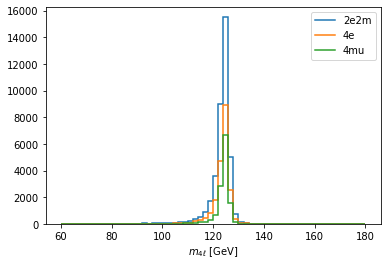

In [12]:
%%time
artists = mc_mass_plot.project('mass', 'channel').plot(stack=True)
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");